In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,f1_score
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline
import torch
import pandas as pd
from tqdm import tqdm

In [6]:
X_train = pd.read_csv("/content/drive/MyDrive/Müş/LLM_Aug/data/X_train.csv")
y_train = pd.read_csv("/content/drive/MyDrive/Müş/LLM_Aug/data/y_train.csv")
X_test = pd.read_csv("/content/drive/MyDrive/Müş/LLM_Aug/data/X_test.csv")
y_test = pd.read_csv("/content/drive/MyDrive/Müş/LLM_Aug/data/y_test.csv")

In [ ]:
#DistilBERT

In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()


In [ ]:
from transformers import pipeline
paraphrase_model = pipeline("text2text-generation", model="eugenesiow/bart-paraphrase")
text = "The gum is tart and sweet for the initial chew but the flavor is almost gone in ten minutes."
paraphrased = paraphrase_model(text, max_length=100, num_return_sequences=4, do_sample=True, temperature=1.8, top_k=50, top_p=0.9,repetition_penalty=2.0,num_workers=5)
for p in paraphrased:
    print("Paraphrased:", p['generated_text'])


Device set to use cuda:0


Paraphrased: The gum is tart and sweet for the initial chew, but the flavor is almost gone in ten minutes.
Paraphrased: The gum is tart and sweet for the initial chew, but the flavor goes away in ten minutes.
Paraphrased: The gum is tart and sweet for the initial chew, but the flavor is almost gone after ten minutes.
Paraphrased: The gum is tart and sweet for the first chew, but the flavor loses in ten minutes.


In [ ]:
from transformers import pipeline

# Modeli yükle
paraphrase_model = pipeline("text2text-generation", model="eugenesiow/bart-paraphrase")

# Farklı prompt stratejileri ile giriş metni
prompt = "Paraphrase the following sentence while keeping its meaning: 'My chips arrived completely pulverized.  They were shipped with no extra packing.  Bummer'"

# Modeli çalıştır
paraphrased_texts = paraphrase_model(
    prompt,
    max_length=100, num_return_sequences=4, do_sample=True, temperature=2.0, top_k=50, top_p=0.9,repetition_penalty=2.0,num_beams=5
)

# Çıktıları yazdır
for idx, paraphrase in enumerate(paraphrased_texts):
    print(f"Paraphrase {idx + 1}: {paraphrase['generated_text']}")


Device set to use cuda:0


Paraphrase 1: Paraphrase the following sentence while keeping its meaning: 'My chips arrived completely pulverized.  They were shipped with no additional packing. Bummer'.
Paraphrase 2: Paraphrase the following sentence while keeping its meaning: 'My chips arrived completely pulverized.  They were shipped with no extra packing. Bummer'
Paraphrase 3: Paraphrase the following sentence while keeping its meaning: 'My chips arrived completely pulverized.  They were shipped with no extra packing. Bummer '
Paraphrase 4: Paraphrase the following sentence while keeping its meaning: 'My chips arrived completely pulverized.  They were shipped with no additional packing. Bummer'


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import pandas as pd
from tqdm import tqdm

# Model ve tokenizer'ı yükleme
model_name = "eugenesiow/bart-paraphrase"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Paraphrasing fonksiyonu
def paraphrase_text(text, max_length=100):
    prompt = f"Rewrite the following differently: {text}"  # Prompt ekleyerek daha iyi sonuç alınabilir.

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)

    outputs = model.generate(
        inputs["input_ids"],
        max_length=max_length,
        num_return_sequences=4,  # Çeşitli paraphrasing seçenekleri almak için
        do_sample=True,  # Sampling aktif edildi
        temperature=1.8,  # Çıktılarda çeşitlilik için sıcaklık artırıldı
        top_k=50,
        top_p=0.9,
        repetition_penalty=2.0,
        num_beams=5  # Beam search ile çeşitliliği artır
    )

    return [tokenizer.decode(output, skip_special_tokens=True).strip() for output in outputs]

# X_train DataFrame üzerinde paraphrasing uygulama
def generate_paraphrased_dataframe(X_train):
    if 'Text' not in X_train.columns:
        raise KeyError(f"Sütun adı 'Text' bulunamadı. Mevcut sütunlar: {X_train.columns}")

    data = []

    for index, row in tqdm(X_train.iterrows(), total=X_train.shape[0], desc="Generating paraphrases"):
        original_text = row['Text']  # 'Text' sütunundan veri al
        paraphrased_texts = paraphrase_text(original_text)
        row_data = [original_text] + paraphrased_texts  # Orijinal + 4 paraphrased versiyon
        data.append(row_data)

    df_paraphrased = pd.DataFrame(data, columns=['original', 'augmented_1', 'augmented_2', 'augmented_3', 'augmented_4'])
    return df_paraphrased

# Paraphrase edilmiş veriyi DataFrame'e dönüştür
df_paraphrased = generate_paraphrased_dataframe(X_train)

# Sonuçları göster
print(df_paraphrased.head())



Generating paraphrases: 100%|██████████| 80/80 [08:38<00:00,  6.49s/it]

                                            original  \
0  They're ok, but not much flavor in the Sea Sal...   
1  i love this tea for dieting its the best i wil...   
2  Maybe I've prepared it wrong, but I haven't be...   
3  A nice little gift, but it's not going to get ...   
4  These cannoli shells are fantastic.  Haven't f...   

                                         augmented_1  \
0  Rewrite the following differently: They're ok,...   
1  Rewrite the following differently: i love this...   
2  Rewrite the following differently: Maybe I've ...   
3  Rewrite the following differently: A nice litt...   
4  Rewrite the following differently: These canno...   

                                         augmented_2  \
0  Rewrite the following differently: They're ok,...   
1  Rewrite the following differently: i love this...   
2  Rewrite the following differently: Maybe I've ...   
3  Rewrite the following differently: A nice litt...   
4  Rewrite the following differently: These ca

In [ ]:
df_paraphrased.iloc[0].values

array(["They're ok, but not much flavor in the Sea Salt & Vinegar flavor. I might try the multigrain flavor.",
       "Rewrite the following differently: They're ok, but not much flavor in the Sea Salt & Vinegar flavor. I might try the multigrain flavor.",
       "Rewrite the following differently: They're ok, but not much flavor in the Sea Salt & Vinegar flavor I might try the multigrain flavor.",
       "Rewrite the following differently: They're ok, but not much flavor in the Sea Salt & Vinegar flavor. I might try the multigrain flavor for it.",
       "Rewrite the following differently: They're ok, but not much flavor in the Sea Salt & Vinegar flavor. I might try the multigrain flavor for a few minutes."],
      dtype=object)

In [ ]:
df_paraphrased.to_csv("/content/drive/MyDrive/Müş/LLM_Aug/bart_augmented.csv",index=False)

In [7]:
df_augmented = pd.read_csv("/content/drive/MyDrive/Müş/LLM_Aug/bart_augmented.csv")

In [ ]:
############################
#veriyi anlamak
df_bart = df_augmented.copy()
df_pegasus = pd.re

In [24]:
df_augmented.iloc[1].values

array(['i love this tea for dieting its the best i will always purchase this tea for me and my family',
       'Rewrite the following differently: i love this tea for dieting its the best i will always purchase this tea in India for me and my family',
       'Rewrite the following differently: i love this tea for dieting its the best i will always purchase this tea in India for me and my family.',
       'Rewrite the following differently: i love this tea for dieting its the best i will always purchase this tea in India for me and family',
       'Rewrite the following differently: i love this tea for dieting its the best i will always purchase this tea. for me and my family'],
      dtype=object)

In [ ]:
#################################

In [8]:
df_2x = pd.concat([df_augmented[['original']], df_augmented[['augmented_1']].rename(columns={"augmented_1": "original"})], ignore_index=True)
y_expanded = pd.concat([y_train, y_train], ignore_index=True)
# Yeni sütunu df_2x'e ekleyelim
df_2x["y"] = y_expanded.values
df_2x

,original,y
0,"They're ok, but not much flavor in the Sea Sal...",2
1,i love this tea for dieting its the best i wil...,4
2,"Maybe I've prepared it wrong, but I haven't be...",1
3,"A nice little gift, but it's not going to get ...",2
4,These cannoli shells are fantastic. Haven't f...,3
...,...,...
155,Rewrite the following differently: We love the...,3
156,Rewrite the following differently: Compact sto...,3
157,Rewrite the following differently: This horcha...,0
158,Rewrite the following differently: Great produ...,4


In [9]:
df_3x = pd.concat([
    df_augmented[['original']],
    df_augmented[['augmented_1']].rename(columns={"augmented_1": "original"}),
    df_augmented[['augmented_2']].rename(columns={"augmented_2": "original"})
], ignore_index=True)

# y_train etiketlerini tekrarlayarak ekle
y_expanded = pd.concat([y_train, y_train, y_train], ignore_index=True)
df_3x["y"] = y_expanded.values
df_3x

,original,y
0,"They're ok, but not much flavor in the Sea Sal...",2
1,i love this tea for dieting its the best i wil...,4
2,"Maybe I've prepared it wrong, but I haven't be...",1
3,"A nice little gift, but it's not going to get ...",2
4,These cannoli shells are fantastic. Haven't f...,3
...,...,...
235,Rewrite the following differently: We love the...,3
236,Rewrite the following differently: Compact sto...,3
237,Rewrite the following differently: This horcha...,0
238,Rewrite the following differently: Great produ...,4


In [10]:
df_5x = pd.concat([
    df_augmented[['original']],
    df_augmented[['augmented_1']].rename(columns={"augmented_1": "original"}),
    df_augmented[['augmented_2']].rename(columns={"augmented_2": "original"}),
    df_augmented[['augmented_3']].rename(columns={"augmented_3": "original"}),
    df_augmented[['augmented_4']].rename(columns={"augmented_4": "original"})
], ignore_index=True)

# y_train değerlerini 5 kez tekrar ederek ekle
y_expanded = pd.concat([y_train] * 5, ignore_index=True)

# Yeni y sütununu ekle
df_5x["y"] = y_expanded.values
df_5x

,original,y
0,"They're ok, but not much flavor in the Sea Sal...",2
1,i love this tea for dieting its the best i wil...,4
2,"Maybe I've prepared it wrong, but I haven't be...",1
3,"A nice little gift, but it's not going to get ...",2
4,These cannoli shells are fantastic. Haven't f...,3
...,...,...
395,Rewrite the following differently: We love the...,3
396,Rewrite the following differently: Compact sto...,3
397,Rewrite the following differently: This horcha...,0
398,Rewrite the following differently: Great produ...,4


In [11]:
y_2x_train=df_2x["y"]
y_3x_train=df_3x["y"]
y_5x_train=df_5x["y"]

#Embedding

In [14]:
X_test_embeddings = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2").encode(X_test["Text"].tolist(),batch_size=32,show_progress_bar=True)
X_original_train_embeddings = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2").encode(X_train["Text"].tolist(),batch_size=32,show_progress_bar=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

In [15]:
X_2x_train_embeddings = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2").encode(df_2x["original"].tolist(),batch_size=32,show_progress_bar=True)

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

In [16]:
X_3x_train_embeddings = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2").encode(df_3x["original"].tolist(),batch_size=32,show_progress_bar=True)

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

In [17]:
X_5x_train_embeddings = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2").encode(df_5x["original"].tolist(),batch_size=32,show_progress_bar=True)

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

## Model Eğitimi

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:54:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model Doğruluğu: 0.25
F1-Score: 0.22


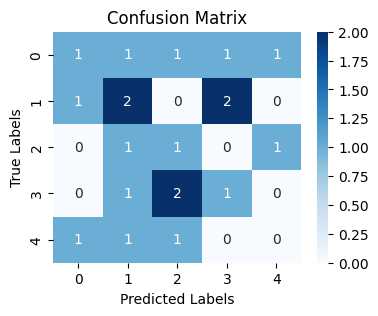

Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.33      0.20      0.25         5
           1       0.33      0.40      0.36         5
           2       0.20      0.33      0.25         3
           3       0.25      0.25      0.25         4
           4       0.00      0.00      0.00         3

    accuracy                           0.25        20
   macro avg       0.22      0.24      0.22        20
weighted avg       0.25      0.25      0.24        20



In [18]:
#Original Data
# XGBoost modelini oluştur
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # Çok sınıflı sınıflandırma için
    num_class=len(np.unique(y_train)), # Sınıf sayısını belirle
    eval_metric='mlogloss',      # Çok sınıflı log loss metriği
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    use_label_encoder=False
)

# Modeli eğit
xgb_model.fit(X_original_train_embeddings, y_train)
# Test seti ile tahmin yap
y_pred = xgb_model.predict(X_test_embeddings)

# Model doğruluğunu hesapla
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Doğruluğu: {accuracy:.2f}")

f1score = f1_score(y_test, y_pred,average="macro")
print(f"F1-Score: {f1score:.2f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0","1","2","3","4"], yticklabels=["0","1","2","3","4"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Sınıflandırma raporunu yazdır
print("Sınıflandırma Raporu:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:54:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model Doğruluğu: 0.25
F1-Score: 0.21


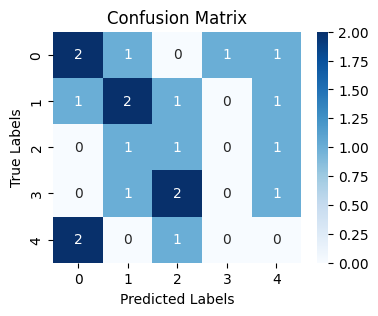

Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.40      0.40      0.40         5
           1       0.40      0.40      0.40         5
           2       0.20      0.33      0.25         3
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         3

    accuracy                           0.25        20
   macro avg       0.20      0.23      0.21        20
weighted avg       0.23      0.25      0.24        20



In [19]:
#2x Data
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # Çok sınıflı sınıflandırma için
    num_class=len(np.unique(y_train)), # Sınıf sayısını belirle
    eval_metric='mlogloss',      # Çok sınıflı log loss metriği
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    use_label_encoder=False
)

# Modeli eğit
xgb_model.fit(X_2x_train_embeddings, y_2x_train)
# Test seti ile tahmin yap
y_pred = xgb_model.predict(X_test_embeddings)

# Model doğruluğunu hesapla
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Doğruluğu: {accuracy:.2f}")

f1score = f1_score(y_test, y_pred,average="macro")
print(f"F1-Score: {f1score:.2f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0","1","2","3","4"], yticklabels=["0","1","2","3","4"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Sınıflandırma raporunu yazdır
print("Sınıflandırma Raporu:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:54:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model Doğruluğu: 0.30
F1-Score: 0.26


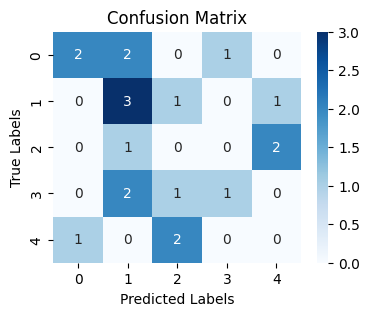

Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.38      0.60      0.46         5
           2       0.00      0.00      0.00         3
           3       0.50      0.25      0.33         4
           4       0.00      0.00      0.00         3

    accuracy                           0.30        20
   macro avg       0.31      0.25      0.26        20
weighted avg       0.36      0.30      0.31        20



In [20]:
#3x Data
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # Çok sınıflı sınıflandırma için
    num_class=len(np.unique(y_train)), # Sınıf sayısını belirle
    eval_metric='mlogloss',      # Çok sınıflı log loss metriği
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    use_label_encoder=False
)

# Modeli eğit
xgb_model.fit(X_3x_train_embeddings, y_3x_train)
# Test seti ile tahmin yap
y_pred = xgb_model.predict(X_test_embeddings)

# Model doğruluğunu hesapla
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Doğruluğu: {accuracy:.2f}")

f1score = f1_score(y_test, y_pred,average="macro")
print(f"F1-Score: {f1score:.2f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0","1","2","3","4"], yticklabels=["0","1","2","3","4"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Sınıflandırma raporunu yazdır
print("Sınıflandırma Raporu:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:54:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model Doğruluğu: 0.25
F1-Score: 0.24


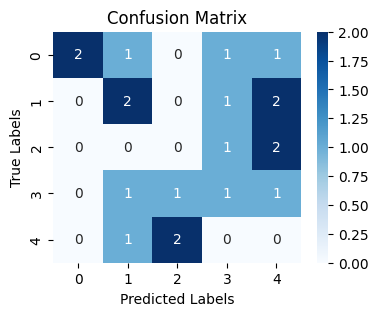

Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.40      0.40      0.40         5
           2       0.00      0.00      0.00         3
           3       0.25      0.25      0.25         4
           4       0.00      0.00      0.00         3

    accuracy                           0.25        20
   macro avg       0.33      0.21      0.24        20
weighted avg       0.40      0.25      0.29        20



In [21]:
#5x Data
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # Çok sınıflı sınıflandırma için
    num_class=len(np.unique(y_train)), # Sınıf sayısını belirle
    eval_metric='mlogloss',      # Çok sınıflı log loss metriği
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    use_label_encoder=False
)

# Modeli eğit
xgb_model.fit(X_5x_train_embeddings, y_5x_train)
# Test seti ile tahmin yap
y_pred = xgb_model.predict(X_test_embeddings)

# Model doğruluğunu hesapla
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Doğruluğu: {accuracy:.2f}")

f1score = f1_score(y_test, y_pred,average="macro")
print(f"F1-Score: {f1score:.2f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0","1","2","3","4"], yticklabels=["0","1","2","3","4"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Sınıflandırma raporunu yazdır
print("Sınıflandırma Raporu:\n", classification_report(y_test, y_pred))